<a href="https://colab.research.google.com/github/d4vidi4n/borradores/blob/main/Proyecto_IC_Jorge_Estrada.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [19]:
import pandas as pd
import numpy as np
import scipy.stats as sp
import matplotlib.pyplot as plt
import time
import os
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV, PredefinedSplit
from sklearn.preprocessing import StandardScaler
from sklearn import svm
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc, precision_recall_curve, average_precision_score, accuracy_score, classification_report

folder = 'figures'
os.makedirs(folder, exist_ok=True)

# 1) Lectura de datos

In [2]:
from google.colab import files
uploaded = files.upload()  # sensorless_tarea3_train.txt
!ls

Saving df_test_no_labels.csv to df_test_no_labels.csv
Saving df_trainval.csv to df_trainval.csv
df_test_no_labels.csv  df_trainval.csv	sample_data


In [3]:
df_trainval = pd.read_csv('df_trainval.csv')
df_test_no_labels = pd.read_csv('df_test_no_labels.csv')
df_trainval

,R1_0,R1_1,R1_2,R1_3,R1_4,R1_5,R1_6,R1_7,R1_8,R1_9,...,Humidity_119,Humidity_120,Humidity_121,Humidity_122,Humidity_123,Humidity_124,Humidity_125,Humidity_126,Humidity_127,class
0,12.73430,12.73430,12.73420,12.73420,12.73550,12.73560,12.73700,12.73740,12.73710,12.73700,...,60.0959,60.1002,60.1041,60.1076,60.1108,60.1137,60.1163,60.1187,60.1208,1
1,11.51190,11.52490,11.53670,11.54820,11.55860,11.56800,11.57650,11.58420,11.59120,11.59770,...,64.9539,64.9585,64.9626,64.9663,64.9684,64.9687,64.9689,64.9691,64.9693,1
2,10.85570,10.85860,10.86130,10.86350,10.86440,10.86490,10.86450,10.86390,10.86280,10.86110,...,56.4906,56.4957,56.5004,56.5045,56.5083,56.5118,56.5149,56.5151,56.5149,1
3,12.55170,12.55180,12.55190,12.55190,12.55200,12.55200,12.55210,12.55210,12.55220,12.55220,...,64.5927,64.5912,64.5898,64.5886,64.5875,64.5865,64.5855,64.5847,64.5839,1
4,8.78442,8.77909,8.77488,8.77016,8.76573,8.76157,8.75735,8.75307,8.74919,8.74538,...,58.2097,58.2229,58.2348,58.2456,58.2553,58.2642,58.2722,58.2794,58.2948,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8791,12.39290,12.39290,12.39260,12.39240,12.39260,12.39240,12.39240,12.39290,12.39280,12.39260,...,49.8931,49.8782,49.8613,49.8459,49.8321,49.8195,49.8082,49.7979,49.7878,3
8792,12.83420,12.83410,12.83410,12.83410,12.83410,12.83410,12.83410,12.83410,12.83410,12.83410,...,53.2695,53.2648,53.2605,53.2592,53.2585,53.2578,53.2572,53.2567,53.2562,3
8793,11.99420,11.99420,11.99400,11.99400,11.99380,11.99390,11.99390,11.99350,11.99360,11.99370,...,67.2733,67.2698,67.2665,67.2636,67.3011,67.3350,67.3656,67.3934,67.4185,3
8794,12.94500,12.94540,12.94560,12.94460,12.94370,12.94260,12.94080,12.94000,12.93950,12.93910,...,52.3949,52.3953,52.3956,52.3960,52.3963,52.3965,52.3968,52.3970,52.3989,3


# 2) Gráfico de algunas señales

Puede ser buena idea graficar una cierta cantidad de datos aleatorios que esten cerca, en grupos de la misma clase de esta manera se pueden ver ciertas correlaciones visuales entre las señales y la clase.

El R_6 puede que esté bastante relacionado con la clase ya que se aprecian lineas rectas separadas por la clase, las de clase 1 quedan abajo mientras que las de clase 2 al medio y las otras de clase 3 tienden a quedar arriba. Aunque igual se aprecia cierta confusión entre las clases 2 y 3. Se aprecia claramente en varias señales con varios sensores que las señales de clase 1 quedan abajo.

Analizando la humedad, no se aprecia ni una correlación, lo que sugiere que probablemente esta característica no es representativo del estímulo.

Puede no ser necesario aplicar un filtro ya que algraficar varias señales, se ven lineas rectas apiladas, donde a priori se conclute que el filtrado realmente no ayudaría a distinguir las líneas porque estas ya se distinguen de esta forma.

Vuelvo a reiterar, es probable que las clases 2 y 3 se confundan al momento de clasificar ya que las líneas se tienden a apilar y casi siempre las de clase 1 quedan abajo y las señales de las otras clases otras a veces se superponen.

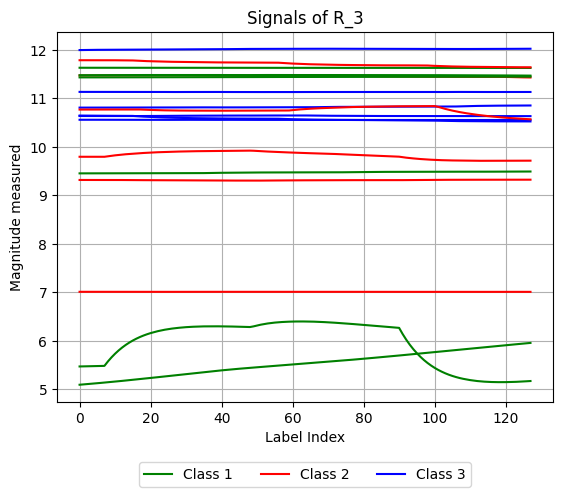

<Figure size 640x480 with 0 Axes>

In [5]:
start = 3 #R_start
idx = [start*128, start*128 + 128]
num_sign_per_graph = 6
rs = 42

# Definición única de parámetros gráficos
plot_kwargs_1 = {
    'color': 'green',
    # 'linestyle': '-',
    # 'marker': '',
    'label': 'Class 1'
}

plot_kwargs_2 = {
    'color': 'red',
    # 'linestyle': '--',
    # 'marker': '.',
    'label': 'Class 2'
}

plot_kwargs_3 = {
    'color': 'blue',
    # 'linestyle': '-.',
    # 'marker': 'x',
    'label': 'Class 3'
}

plt.figure()
plt.grid()
plt.xlabel('Label Index')
plt.ylabel('Magnitude measured')
plt.title(f'Signals of R_{start}')

for i in range(num_sign_per_graph):
  plt.plot(np.arange(0,128), df_trainval[df_trainval['class']==1].sample(n=num_sign_per_graph, random_state=rs).iloc[i][idx[0]:idx[1]], **plot_kwargs_1)
  plt.plot(np.arange(0,128), df_trainval[df_trainval['class']==2].sample(n=num_sign_per_graph, random_state=rs).iloc[i][idx[0]:idx[1]], **plot_kwargs_2)
  plt.plot(np.arange(0,128), df_trainval[df_trainval['class']==3].sample(n=num_sign_per_graph, random_state=rs).iloc[i][idx[0]:idx[1]], **plot_kwargs_3)
  if i == 0:
    plt.legend(loc=8, bbox_to_anchor=(0.5, -0.25), ncol=3)
plt.show()

filename = f'signals_R{start}.svg'
filepath = os.path.join(folder, filename)
plt.savefig(filepath)


No se aprecian oscilaciones de ni un tipo, por lo que no se hará un análisis en frecuencia

# 3) Eliminar señales o no

# 4) Filtrado de la señal
No pq no hay ruido ni componentes periodicas que pudieran requerir la extracción de carcaterísticas frecuenciales

# 5) Definición de las características

Vector de cálculo de características (Media, Varianza, etc) ()

In [6]:
from statsmodels.tsa.ar_model import AutoReg

def get_single_ar_coeff(signal, order=3, method='mean'):
    try:
        model = AutoReg(signal, lags=order, old_names=False)
        result = model.fit()
        coeffs = result.params[1:]  # Ignorar el intercepto
        if method == 'mean':
            return np.mean(coeffs)
        elif method == 'norm':
            return np.linalg.norm(coeffs)
        elif method == 'first':
            return coeffs[0]
        elif method == 'max_abs':
            return coeffs[np.argmax(np.abs(coeffs))]
        else:
            return np.nan
    except:
        return np.nan

In [7]:
def extract_features(signal):
  STD_THRESHOLD = 1e-12

  is_constant = np.std(signal) < STD_THRESHOLD
  # is_constant = np.std(signal) == 0
  is_too_short = len(signal) < 2

  return {
      'mean': np.mean(signal),
      # 'var': np.var(signal),
      # 'mad': np.median(np.abs(signal - np.median(signal))),
      # 'max': np.max(signal),
      # 'min': np.min(signal),
      # 'sma': np.sum(np.abs(signal)),
      # 'enrgy': np.sum(signal**2) / len(signal),
      # 'iqr': sp.iqr(signal),
      # 'entpy': sp.entropy(signal),
      # 'arCoeff': get_single_ar_coeff(signal),  # Placeholder; lo puedes reemplazar cuando tengas la función
      # 'corr': 0.0 if is_constant or is_too_short else np.corrcoef(signal[:-1], signal[1:])[0, 1]
  }

def calculation_feature_vector(df_data):
    sensors = [f'R{j}' for j in range(1, 9)] + ['Humidity']
    feature_list = []

    # for idx, row in df_data[8215:8220].iterrows():
    # for idx, row in df_data[8216:8217].iterrows(): #Dato problemático -> df_data.iloc[8216]
    for idx, row in df_data.iterrows():
        features = {}
        for sensor in sensors:
            start_col = f'{sensor}_0'
            end_col = f'{sensor}_127'
            signal = row[start_col:end_col].to_numpy()
            feats = extract_features(signal)
            # Prefix feature names with sensor ID
            feats_prefixed = {f'{key}_{sensor}': value for key, value in feats.items()}
            features.update(feats_prefixed)
        if 'class' in df_data.columns:
            features['class'] = row['class']
        feature_list.append(features)

    df_features = pd.DataFrame(feature_list)
    return df_features

# train_val_data = calculation_feature_vector(df_trainval)
# df_test = calculation_feature_vector(df_test_no_labels)

Hay un caso de un sample que da un valor muy bajo en la varianza, esto genra una división por cero, por esta razón de establecerá una forma de lidiar con este caso y evitar que haya un NaN

In [8]:
train_val_data = calculation_feature_vector(df_trainval)
df_test_data = calculation_feature_vector(df_test_no_labels)

In [9]:
df_train, df_val = train_test_split(train_val_data, test_size=0.3, random_state=10, stratify=train_val_data['class'])
df_test = df_test_data.copy()

In [10]:
# df_test = calculation_feature_vector(df_test_no_labels)
scaler = StandardScaler().fit(df_train.iloc[:,0:-1])

df_train.iloc[:,0:-1] = scaler.transform(df_train.iloc[:,0:-1])
df_val.iloc[:,0:-1] = scaler.transform(df_val.iloc[:,0:-1])
df_test.iloc[:,0:] = scaler.transform(df_test_data.iloc[:,0:])

df_train_w_class = df_train.copy()
df_val_w_class = df_val.copy()

y_train = df_train.pop('class')# - 1
y_val = df_val.pop('class')# - 1

In [11]:
df_train_w_class
df_test

,mean_R1,mean_R2,mean_R3,mean_R4,mean_R5,mean_R6,mean_R7,mean_R8,mean_Humidity
0,0.278288,-1.959289,-2.340707,-1.937812,-0.200561,-0.120336,-0.873444,-0.699190,-0.992923
1,-2.050745,-2.264917,-2.213663,-2.276574,-0.174610,0.044062,-0.773467,-0.732227,-0.269053
2,0.376632,0.266031,0.323802,0.269374,-0.383765,0.437211,0.187633,0.219720,-0.941613
3,0.743021,0.548202,0.560221,0.561917,1.509999,-1.264436,0.248346,0.066275,0.424622
4,0.505877,0.727610,0.729714,0.734462,-0.251115,0.265011,0.269936,0.271763,-0.972053
...,...,...,...,...,...,...,...,...,...
4006,0.734664,0.806217,0.721635,0.658088,-0.488041,0.112866,-0.416111,-0.407549,0.086991
4007,0.568090,0.408823,0.468190,0.405310,-0.034166,0.513315,0.246401,0.291492,-1.371525
4008,0.616625,0.957723,0.952113,0.977560,-0.014178,-0.045810,-0.484626,-0.564540,0.597270
4009,1.174632,0.906596,0.886622,0.888156,-0.030831,-0.926882,0.048659,0.039254,-1.148815


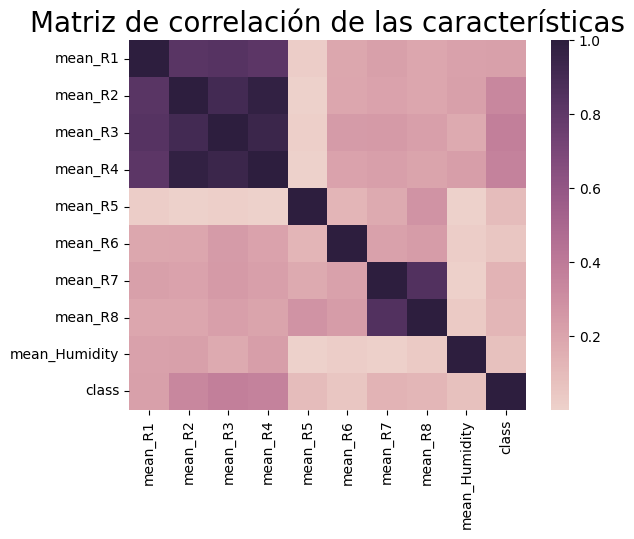

In [13]:
# plt.figure(figsize=(24, 18))
correlation_data = df_train_w_class.corr(method='pearson')
correlation_data_abs_value = abs(df_train_w_class.corr(method='pearson'))
sns.heatmap(correlation_data_abs_value, cmap=sns.cubehelix_palette(as_cmap=True))
plt.title("Matriz de correlación de las características", fontsize=20)
plt.savefig('corr_lineal.svg', format='svg', bbox_inches='tight', pad_inches=0)

Eliminación de señales/características

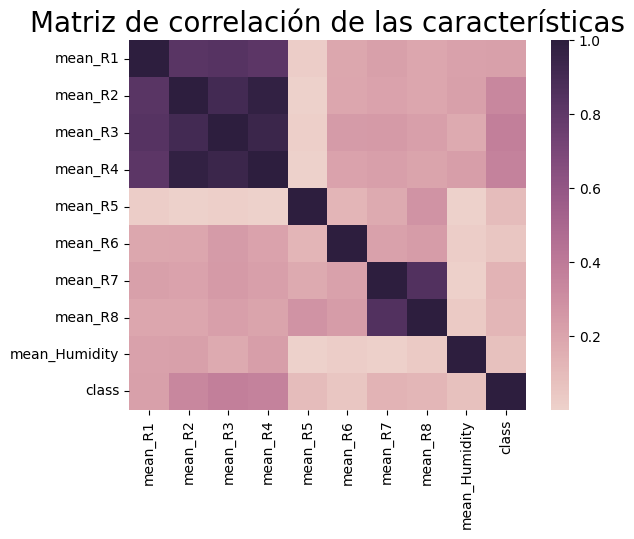

In [14]:
df_aux = df_train.iloc[:,:44]
df_aux['class'] = y_train
df_train_w_class = df_aux.copy()
# display(df_train_w_class)

df_aux = df_val.iloc[:,:44]
df_aux['class'] = y_val
df_val_w_class = df_aux.copy()

df_test = df_test.iloc[:,:44]

# plt.figure(figsize=(24, 18))
correlation_data = df_train_w_class.corr(method='pearson')
correlation_data_abs_value = abs(df_train_w_class.corr(method='pearson'))
sns.heatmap(correlation_data_abs_value, cmap=sns.cubehelix_palette(as_cmap=True))
plt.title("Matriz de correlación de las características", fontsize=20)
plt.savefig('corr_lineal.svg', format='svg', bbox_inches='tight', pad_inches=0)

# 7) Elección y entrenamiento de un clasificador

Permutación predefinida para la validación del modelo

In [15]:
def predefined_split(class_val):
  n_samples = len(class_val)                                        # Longitud del set de datos de validación, este dato se usará para definir que elementos se usarán para entrenamiento y validación en GridSearchCV()
  n_train_grid_search = int(n_samples * 0.7)                    # 80% de los datos utilizdos para entrenamiento
  n_val_grid_search = n_samples - n_train_grid_search           # El 20% restante para validación

  np.random.seed(42)
  indices = np.random.permutation(n_samples)                    # Tomar índices de forma aleatoria
  test_fold = np.full(n_samples, -1)                        # Se define el arreglo de los índices de elemntos de train y test

  # Asignar 1 a los índices que serán test
  test_indices = indices[:n_val_grid_search]
  test_fold[test_indices] = 1

  ps = PredefinedSplit(test_fold)

  return ps

In [16]:
n_features = df_val.shape[1]
gamma_default = 1 / (n_features * df_val.var().mean())

In [17]:
def make_clf(svc, params_svc, df_t, y_t, df_v, y_v):

  clf = GridSearchCV(svc, params_svc, cv=ps) #ps es una variable global, no se coloca como entrada para reducir al máximo las entradas de la función y hacer menos confusa las iteraciones

  # GridSearch
  t0 = time.time()
  clf.fit(df_v, y_v)
  t = time.time()
  tiempo_svm_lin_grid_search = t - t0
  print('Tiempo GridSearch SVM lineal: ',tiempo_svm_lin_grid_search)

  display(pd.DataFrame(clf.cv_results_)) # Resultados del GridSearchCV()

  best_clf = clf.best_estimator_ # Se extraen los mejores hiperparámetros calculados a través de GridSearchCV()

  # Entrenamiento del SVM lineal con el conjunto de entrenamiento
  t0 = time.time()
  best_clf.fit(df_t, y_t)
  t = time.time()
  tiempo_svm_lin_training = t - t0
  print('Tiempo entrenamiento SVM lineal: ',tiempo_svm_lin_training)

  print('Tiempo GridSearch + Entrenamiento =',tiempo_svm_lin_grid_search+tiempo_svm_lin_training)

  return best_clf

In [20]:
ps = predefined_split(y_val)

parameters = {'C':[200, 500, 1000, 2000], 'degree':[2,3,4,5]}
svc = svm.SVC(kernel='poly', coef0=1, gamma='scale')
best_model = make_clf(svc, parameters, df_train, y_train, df_val, y_val)

y_pred = best_model.predict(df_val) # Predicción del conjunto de validación

Tiempo GridSearch SVM lineal:  131.3739368915558


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_degree,params,split0_test_score,mean_test_score,std_test_score,rank_test_score
0,1.066240,0.0,0.025554,0.0,200,2,"{'C': 200, 'degree': 2}",0.785354,0.785354,0.0,15
1,2.006669,0.0,0.020620,0.0,200,3,"{'C': 200, 'degree': 3}",0.835859,0.835859,0.0,11
2,2.301219,0.0,0.017465,0.0,200,4,"{'C': 200, 'degree': 4}",0.854798,0.854798,0.0,8
3,2.358783,0.0,0.017039,0.0,200,5,"{'C': 200, 'degree': 5}",0.891414,0.891414,0.0,3
4,3.747038,0.0,0.040027,0.0,500,2,"{'C': 500, 'degree': 2}",0.796717,0.796717,0.0,13
5,6.344802,0.0,0.019695,0.0,500,3,"{'C': 500, 'degree': 3}",0.833333,0.833333,0.0,12
6,3.202432,0.0,0.016255,0.0,500,4,"{'C': 500, 'degree': 4}",0.866162,0.866162,0.0,7
7,5.253734,0.0,0.014072,0.0,500,5,"{'C': 500, 'degree': 5}",0.883838,0.883838,0.0,5
8,5.317882,0.0,0.023564,0.0,1000,2,"{'C': 1000, 'degree': 2}",0.789141,0.789141,0.0,14
9,20.240794,0.0,0.018709,0.0,1000,3,"{'C': 1000, 'degree': 3}",0.849747,0.849747,0.0,9


Tiempo entrenamiento SVM lineal:  45.22736859321594
Tiempo GridSearch + Entrenamiento = 176.60130548477173


Borrador de la celda previa:

In [ ]:
ps = predefined_split(y_val)

# 1° iteración:
# parameters = {'C':[0.01, 0.1, 1, 10, 100]}
# svc = svm.SVC(kernel='linear') #decision_function_shape{‘ovo’, ‘ovr’}, default=’ovr’

# 2° iteración:
# parameters = {'C':[0.1, 1, 10], 'degree':[2,3,4]}
# svc = svm.SVC(kernel='poly', coef0=1, gamma='scale')

# 2° a) iteración:
# parameters = {'C':[0.1, 1, 10, 100, 200], 'degree':[2,3,4]}
# parameters = {'C':[0.1, 1, 10, 100, 1000], 'degree':[2,3,4],'kernel':['poly']}
# svc = svm.SVC(kernel='poly', coef0=1, gamma='scale')

# 2° a) iteración:
# parameters = {'C':[100, 200, 500, 1000], 'degree':[2,3,4]}
# parameters = {'C':[100, 200, 500, 1000], 'degree':[2,3,4], 'kernel':['poly']}
# parameters = {'C':[200, 500, 1000, 5000], 'degree':[2,3,4], 'coef0':[-5, -1, 1, 5]}
# svc = svm.SVC(kernel='poly', coef0=1, gamma='scale')
parameters = {'C':[200, 500, 1000, 2000], 'degree':[2,3,4,5]}
svc = svm.SVC(kernel='poly', coef0=1, gamma='scale')
# parameters = {'C':[200, 500, 1000, 2000], 'degree':[2,3,4],'gamma':[gamma_default*0.01, gamma_default*0.1, gamma_default, gamma_default*10, gamma_default*100]}
# svc = svm.SVC(kernel='poly', coef0=1)

# svc = svm.SVC(kernel='poly', gamma='scale')
# svc = svm.SVC(kernel='poly', coef0=1, gamma='scale')

# 3° iteración:
# parameters = {'C':[0.01, 0.1, 1, 10, 100], 'degree':[2,3,4], 'coef0':[-1, 1]}
# parameters = {'C':[0.01, 0.1, 1, 10, 100], 'kernel':['poly'], 'degree':[2,3,4], 'coef0':[-1, 1]} #Probado el 10/07, debo definir el kernel dentro de los parámetros
# svc = svm.SVC(kernel='poly', gamma='scale')
# Poco viable por el timepo de entrenamiento que toma

# 4° iteración:
# parameters = {'kernel':['rbf'],'C':[0.01, 0.1, 1, 10, 100],'gamma':[gamma_default*0.01, gamma_default*0.1, gamma_default, gamma_default*10, gamma_default*100]}
# parameters = {'kernel':['rbf'],'C':[1, 10, 100, 1000, 2000],'gamma':[gamma_default*0.01, gamma_default*0.1, gamma_default, gamma_default*10, gamma_default*100]}
# svc = svm.SVC(kernel='rbf')

# 5° iteración: (09/07) Selección del kernel mediante el GridSearch
# parameters = {'C':[0.01, 0.1, 1, 10, 100], 'kernel':['poly', 'rbf']} #Al tener como resultado el mayor C, se plantea un nuevo conjunto de valores C para el GridSearch
# parameters = {'C':[100, 200, 500, 1000, 2000],'kernel':['linear', 'poly', 'rbf', 'sigmoid']}
# parameters = {'C':[0.01, 0.1, 1, 10, 100],'kernel':['linear', 'poly', 'rbf', 'sigmoid']}  #--------> Para probar el mejor kernel
# parameters = {'C':[0.01, 0.1, 1, 10, 100],'kernel':['linear', 'poly', 'rbf', 'sigmoid']} #Al tener como resultado el mayor C, se plantea un nuevo conjunto de valores C para el GridSearch
# parameters = {'C':[0.1, 1, 10, 100], 'kernel':['rbf'], 'gamma':[gamma_default*0.01, gamma_default*0.1, gamma_default, gamma_default*10, gamma_default*100]}
# parameters = {'C':[1, 10, 100, 200], 'kernel':['rbf'], 'gamma':[gamma_default*0.01, gamma_default*0.1, gamma_default, gamma_default*10]} #Probado el 10/07
# parameters = {'C':[1, 10, 100], 'kernel':['rbf'], 'gamma':[gamma_default*0.01, gamma_default*0.1, gamma_default, gamma_default*10]} # Pruebo este vector el 10/07 para verificar el clasificador con el nuevo vector de características y de esta forma evaluar el tiempo de cálculo y el nuevo vector
# parameters = {'C':[0.01, 0.1, 1, 10, 100],'kernel':['sigmoid','poly', 'rbf']} #Al tener como resultado el mayor C, se plantea un nuevo conjunto de valores C para el GridSearch

best_model = make_clf(svc, parameters, df_train, y_train, df_val, y_val)
# best_model = make_clf(parameters, df_train.iloc[:,0:44], y_train, df_val.iloc[:,0:44], y_val)

y_pred = best_model.predict(df_val) # Predicción del conjunto de validación
# y_pred = best_model.predict(df_val.iloc[:,0:44]) # Predicción del conjunto de validación

Tiempo GridSearch SVM lineal:  129.43655729293823


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_degree,params,split0_test_score,mean_test_score,std_test_score,rank_test_score
0,1.059953,0.0,0.025252,0.0,200,2,"{'C': 200, 'degree': 2}",0.785354,0.785354,0.0,15
1,1.968902,0.0,0.026243,0.0,200,3,"{'C': 200, 'degree': 3}",0.835859,0.835859,0.0,11
2,2.271038,0.0,0.017093,0.0,200,4,"{'C': 200, 'degree': 4}",0.854798,0.854798,0.0,8
3,3.453155,0.0,0.025424,0.0,200,5,"{'C': 200, 'degree': 5}",0.891414,0.891414,0.0,3
4,2.511131,0.0,0.023767,0.0,500,2,"{'C': 500, 'degree': 2}",0.796717,0.796717,0.0,13
5,6.270993,0.0,0.026727,0.0,500,3,"{'C': 500, 'degree': 3}",0.833333,0.833333,0.0,12
6,4.300199,0.0,0.026990,0.0,500,4,"{'C': 500, 'degree': 4}",0.866162,0.866162,0.0,7
7,3.811153,0.0,0.015512,0.0,500,5,"{'C': 500, 'degree': 5}",0.883838,0.883838,0.0,5
8,5.232903,0.0,0.023627,0.0,1000,2,"{'C': 1000, 'degree': 2}",0.789141,0.789141,0.0,14
9,19.762902,0.0,0.019646,0.0,1000,3,"{'C': 1000, 'degree': 3}",0.849747,0.849747,0.0,9


Tiempo entrenamiento SVM lineal:  33.46855592727661
Tiempo GridSearch + Entrenamiento = 162.90511322021484


En la primera iteración, usando este clasificador:
```
parameters = {'C':[0.01, 0.1, 1, 10, 100]}
svc = svm.SVC(kernel='linear')
```
Obviamente con los hiperparámetros validados se aprecia una muy baja precisión a la hora de detectar las clases 1 y 2

In [18]:
def post_proc(y_v, y_pr):
  accu_score = accuracy_score(y_val, y_pred)
  plt.title(f'Params: C={best_model.C}\nAccuracy = {accu_score:.4f}', fontsize = 10)
  sns.heatmap(np.round(confusion_matrix(y_val, y_pred, normalize='true'), decimals=6), annot=True, cmap=sns.cubehelix_palette(as_cmap=True), xticklabels=[1, 2, 3],yticklabels=[1, 2, 3])
  plt.suptitle('Matriz de confusión normalizada SVM lineal', x=0.43, y=1.005)
  # for text in disp_norm.text_.ravel():
  #     text.set_fontsize(14) # Ajusta fontsize

  filename = f'mat_conf_.svg'
  filepath = os.path.join(folder, filename)
  plt.savefig(filepath)

  plt.savefig('conf_mat_svm.svg')

  plt.show()

SyntaxError: incomplete input (ipython-input-18-549741804.py, line 1)

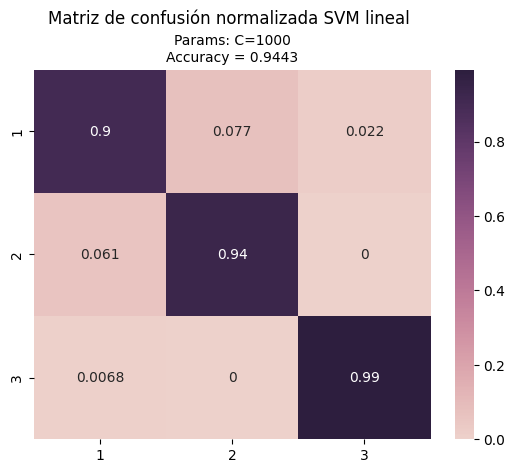

In [21]:
accu_score = accuracy_score(y_val, y_pred)
plt.title(f'Params: C={best_model.C}\nAccuracy = {accu_score:.4f}', fontsize = 10)
sns.heatmap(np.round(confusion_matrix(y_val, y_pred, normalize='true'), decimals=6), annot=True, cmap=sns.cubehelix_palette(as_cmap=True), xticklabels=[1, 2, 3],yticklabels=[1, 2, 3])
plt.suptitle('Matriz de confusión normalizada SVM lineal', x=0.43, y=1.005)
# for text in disp_norm.text_.ravel():
#     text.set_fontsize(14) # Ajusta fontsize
plt.savefig('conf_mat_svm.svg')

plt.show()

# Primera iteración de predicción del conjunto de test
Pendiente hacer una función con esto

In [ ]:
y_pred_test = best_model.predict(df_test)

with open('pred_test.csv', 'w') as f:
  f.write('Id,Category\n')
  for i in range(len(df_test)):
    f.write(f'{df_test.index[i]},{int(y_pred_test[i])}\n')

In [ ]:
y_pred_test[dtype:=int]

IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

In [ ]:
df_test

,mean_R1,var_R1,mad_R1,max_R1,min_R1,sma_R1,enrgy_R1,iqr_R1,entpy_R1,arCoeff_R1,...,var_Humidity,mad_Humidity,max_Humidity,min_Humidity,sma_Humidity,enrgy_Humidity,iqr_Humidity,entpy_Humidity,arCoeff_Humidity,corr_Humidity
0,12.433211,0.000234,0.01225,12.4769,12.4132,1591.4510,154.584968,0.023225,4.852030,0.331766,...,0.002420,0.03055,52.8140,52.6294,6747.5776,2778.921089,0.087825,4.852030,0.332980,0.998884
1,10.449923,0.072499,0.18975,10.8093,10.0466,1337.5901,109.273383,0.529275,4.851697,0.332147,...,0.066275,0.24525,56.6335,55.7756,7197.4745,3161.909487,0.439025,4.852020,0.331806,0.997610
2,12.516956,0.000414,0.01830,12.5466,12.4876,1602.1704,156.674607,0.044375,4.852029,0.333031,...,0.011577,0.07150,53.1910,52.8202,6779.4676,2805.259437,0.218375,4.852028,0.332804,0.997943
3,12.828955,0.000004,0.00100,12.8321,12.8235,1642.1062,164.582082,0.001950,4.852030,0.325841,...,0.000307,0.01450,59.6298,59.5671,7628.6046,3551.978343,0.034025,4.852030,0.332911,0.996884
4,12.627014,0.000008,0.00205,12.6327,12.6222,1616.2578,159.441492,0.004725,4.852030,0.327133,...,0.000093,0.00690,52.8351,52.7937,6760.5490,2789.613299,0.014000,4.852030,0.328055,0.989487
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4006,12.821838,0.000309,0.00475,12.8344,12.7749,1641.1953,164.399846,0.010975,4.852029,0.330147,...,0.264561,0.13455,59.3176,57.5039,7418.7616,3359.518936,0.392750,4.851991,0.330916,0.999411
4007,12.679992,0.000118,0.00730,12.7025,12.6676,1623.0390,160.782320,0.016200,4.852030,0.330987,...,0.021718,0.04170,51.0027,50.5059,6512.2708,2588.502613,0.139375,4.852026,0.333919,0.999734
4008,12.721322,0.000326,0.01355,12.7437,12.6837,1628.3292,161.832356,0.024375,4.852029,0.331328,...,0.001082,0.03060,60.4799,60.3742,7735.9084,3652.605987,0.057875,4.852030,0.331757,0.997640
4009,13.196493,0.000292,0.01600,13.2218,13.1748,1689.1511,174.147719,0.035675,4.852029,0.331892,...,0.013211,0.06420,52.2437,51.7893,6650.6882,2699.699095,0.160800,4.852028,0.331274,0.996349


In [ ]:
y_pred_test

array([1., 1., 1., ..., 1., 1., 1.])

# II) Nuevo vector de características
Se prueba un nuevo vector de características, esta vez incluyendo características tales como el mínimo, el máximo y la media móvil, entre otras.

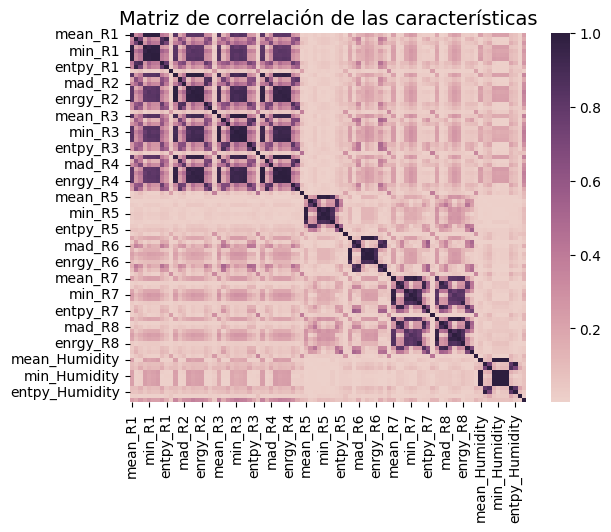

In [ ]:
# correlation_data = df_train_w_class[df_train_w_class['class']==3].corr(method='pearson')
# correlation_data_abs_value = abs(df_train_w_class[df_train_w_class['class']==3].corr(method='pearson'))

correlation_data = df_train_w_class.corr(method='pearson')
correlation_data_abs_value = abs(df_train_w_class.corr(method='pearson'))
sns.heatmap(correlation_data_abs_value, cmap=sns.cubehelix_palette(as_cmap=True))
plt.title("Matriz de correlación de las características", fontsize=14)
plt.savefig('corr_lineal.svg', format='svg', bbox_inches='tight', pad_inches=0)

Se concluye que la media es lo que hace una clasificación relativamente exitosa (50% de corr con la clase), pero la varianza no ayuda en nada (por debajo de 30% de corr con la clase para las primeras 4 características y caso 0% para el resto). Así que se calcula un nuevo vector de carcaterísticas. Finalmente lo dejé solo con la media y el mismo clasificador que usé al inicio con el 1er vector de carcaterísticas que usé (media y varianza). Ahora lo que queda pendiente es usar otras características para justificar que la media es la mejor.

In [ ]:
def calculation_feature_vector_2(df_data):

  caracs_list = []

  big_data_arr = np.zeros((len(df_data), 18))

  for i in range(0, len(df_data)):
  # for i in range(0, 2):
    data_list = []

    for j in range(1,10):

      if j == 9:
        df_calc = df_data.loc[i, f'Humidity_0':f'Humidity_127'] #display(df_trainval.loc[i, f'Humidity_0':f'Humidity_127'])
      else:
        df_calc = df_data.loc[i, f'R{j}_0':f'R{j}_127'] #display(df_trainval.loc[i, f'R{j}_0':f'R{j}_127'])

      if i == 0:
        # 2° it features
        caracs_list.append('mean_' + str(j))
        # caracs_list.append('var_' + str(j))
        # caracs_list.append('min_' + str(j))
        # caracs_list.append('max_' + str(j))
        # caracs_list.append('sma_' + str(j))
        caracs_list.append('slope_' + str(j))

        df = pd.DataFrame(columns=caracs_list)

      data_list.append(np.mean(df_calc))
      # data_list.append(np.var(df_calc))
      # data_list.append(min(df_calc))
      # data_list.append(max(df_calc))
      # data_list.append(np.ma.average(df_calc))
      # 'slope': np.polyfit(x, signal, 1)[0]
      data_list.append(np.polyfit(np.arange(128), df_calc, 1)[0]) #Nueva carcaterística, probada hoy (08/07) al final del día

    # print(i)
    big_data_arr[i,:] = np.array(data_list)

  df = pd.DataFrame(big_data_arr, columns=caracs_list)

  if 'class' in df_data.columns:
    df = pd.concat([df, df_data['class']], axis=1)

  return df

In [ ]:
train_val_data_II = calculation_feature_vector_2(df_trainval)
df_test = calculation_feature_vector_2(df_test_no_labels)

In [ ]:
df_train, df_val = train_test_split(train_val_data_II, test_size=0.3, random_state=10, stratify=train_val_data_II['class'])

scaler = StandardScaler().fit(df_train.iloc[:,0:18])

df_train.iloc[:,0:18] = scaler.transform(df_train.iloc[:,0:18])
df_val.iloc[:,0:18] = scaler.transform(df_val.iloc[:,0:18])
df_test.iloc[:,0:18] = scaler.transform(df_test.iloc[:,0:18])

df_train_w_class = df_train.copy()
df_val_w_class = df_val.copy()

y_train = df_train.pop('class')# - 1
y_val = df_val.pop('class')# - 1

In [ ]:
# 1° iteración:
# parameters = {'C':[0.01, 0.1, 1, 10, 100]}
# svc = svm.SVC(kernel='linear')

# 2° iteración:
# parameters = {'C':[0.1, 1, 10], 'degree':[2,3,4]}
# svc = svm.SVC(kernel='poly', coef0=1, gamma='scale')

# 3° iteración:
parameters = {'C':[200, 500, 1000, 5000], 'degree':[2,3,4]}
svc = svm.SVC(kernel='poly', coef0=1, gamma='scale')

clf = GridSearchCV(svc, parameters, cv=ps)

# GridSearch
t0 = time.time()
clf.fit(df_val, y_val)
t = time.time()
tiempo_svm_lin_grid_search = t - t0
print('Tiempo GridSearch SVM lineal: ',tiempo_svm_lin_grid_search)

display(pd.DataFrame(clf.cv_results_)) # Resultados del GridSearchCV()

best_model = clf.best_estimator_ # Se extraen los mejores hiperparámetros calculados a través de GridSearchCV()
# svc_lin = svm.SVC(kernel='linear', C=best_model.C)# Se define un nuevo SVM con los mejores hiperparámetros

# Entrenamiento del SVM lineal con el conjunto de entrenamiento
t0 = time.time()
best_model.fit(df_train, y_train)
t = time.time()
tiempo_svm_lin_training = t - t0
print('Tiempo entrenamiento SVM lineal: ',tiempo_svm_lin_training)

print('Tiempo GridSearch + Entrenamiento =',tiempo_svm_lin_grid_search+tiempo_svm_lin_training)
y_pred = best_model.predict(df_val) # Predicción del conjunto de validación

Tiempo GridSearch SVM lineal:  61.976420164108276


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_degree,params,split0_test_score,mean_test_score,std_test_score,rank_test_score
0,1.018333,0.0,0.011343,0.0,200,2,"{'C': 200, 'degree': 2}",0.744318,0.744318,0.0,12
1,1.047324,0.0,0.010636,0.0,200,3,"{'C': 200, 'degree': 3}",0.770833,0.770833,0.0,6
2,0.560614,0.0,0.010375,0.0,200,4,"{'C': 200, 'degree': 4}",0.776515,0.776515,0.0,4
3,2.173436,0.0,0.011307,0.0,500,2,"{'C': 500, 'degree': 2}",0.757576,0.757576,0.0,11
4,1.967388,0.0,0.010329,0.0,500,3,"{'C': 500, 'degree': 3}",0.765152,0.765152,0.0,8
5,1.060306,0.0,0.019062,0.0,500,4,"{'C': 500, 'degree': 4}",0.787879,0.787879,0.0,2
6,5.822738,0.0,0.011416,0.0,1000,2,"{'C': 1000, 'degree': 2}",0.767045,0.767045,0.0,7
7,3.483835,0.0,0.010139,0.0,1000,3,"{'C': 1000, 'degree': 3}",0.776515,0.776515,0.0,4
8,1.310107,0.0,0.009385,0.0,1000,4,"{'C': 1000, 'degree': 4}",0.789773,0.789773,0.0,1
9,22.213246,0.0,0.012116,0.0,5000,2,"{'C': 5000, 'degree': 2}",0.759470,0.759470,0.0,9


Tiempo entrenamiento SVM lineal:  62.27792811393738
Tiempo GridSearch + Entrenamiento = 124.25434827804565


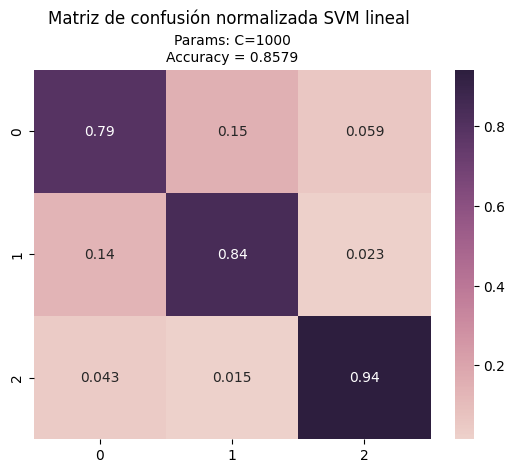

In [ ]:
accu_score = accuracy_score(y_val, y_pred)
plt.title(f'Params: C={best_model.C}\nAccuracy = {accu_score:.4f}', fontsize = 10)
sns.heatmap(np.round(confusion_matrix(y_val, y_pred, normalize='true'), decimals=4), annot=True, cmap=sns.cubehelix_palette(as_cmap=True))
plt.suptitle('Matriz de confusión normalizada SVM lineal', x=0.43, y=1.005)
# for text in disp_norm.text_.ravel():
#     text.set_fontsize(14) # Ajusta fontsize
plt.savefig('conf_mat_svm.svg')

plt.show()

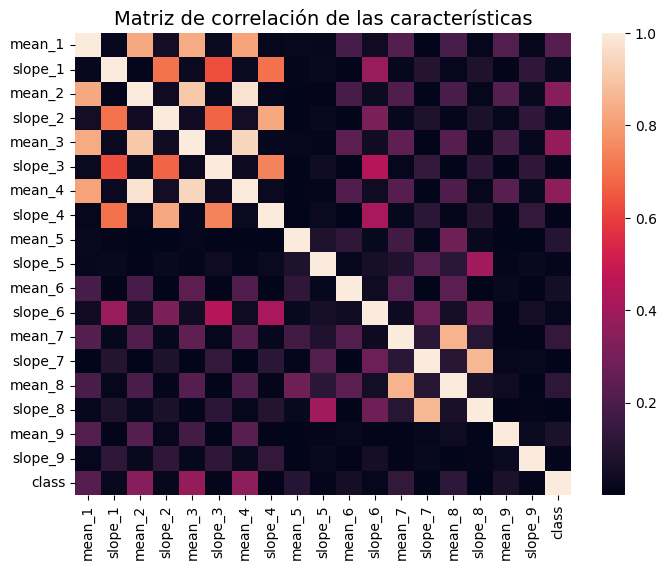

In [ ]:
plt.figure(figsize=(8,6))
correlation_data = df_train_w_class[df_train_w_class['class']==3].corr(method='pearson')
correlation_data_abs_value = abs(df_train_w_class[df_train_w_class['class']==3].corr(method='pearson'))

correlation_data = df_train_w_class.corr(method='pearson')
correlation_data_abs_value = abs(df_train_w_class.corr(method='pearson'))
sns.heatmap(correlation_data_abs_value)
plt.title("Matriz de correlación de las características", fontsize=14)
plt.savefig('corr_lineal.svg', format='svg', bbox_inches='tight', pad_inches=0)

Se concluye que la pendiente no tiene una importancia comparable a la de la media en la clasificación de las señales, pero debo sacar el gráfico anterior (matriz de correlación con la clase con las cracterísticas, que sería la media de cada señal) para realmente poder comparar como corresponde y decir porque la pendiente no sirve para clasificar las señales

## Segunda iteración de predicción del conjunto de test

In [ ]:
def test_pred_function(df_te, model):
  y_test_pred = model.predict(df_te)
  with open('pred_test_JE.csv', 'w') as f:
    f.write('Id,Category\n')
    for i in range(len(df_te)):
      f.write(f'{df_te.index[i]},{y_test_pred[i]}\n')

test_pred_function(df_test, best_model)

# III) Cascada de clasificadores
Se clasifica la clase 3 y luego se clasifican las 1 y 2 por separado, del punto anterior se concluyó, con respecto al vecotr de carcaterísticas, que la mejor característica para clasificar la data resultó ser la media, yq eu otras características como la varianza, skew o sma solo mantienen el accuracy o incluso lo disminuyen como sucedió con la varianza, en el primer vector de características se vió que esta carcatrística solo emperoraba el rendimiento general, ya que al quitarla y además aumentar el C, el clasificador pasó de tener un accuracy de validación de 86% a 92%.

In [ ]:
def calculation_feature_vector_2(df_data):

  caracs_list = []

  big_data_arr = np.zeros((len(df_data), 9))

  for i in range(0, len(df_data)):
  # for i in range(0, 2):
    data_list = []

    for j in range(1,10):

      if j == 9:
        df_calc = df_data.loc[i, f'Humidity_0':f'Humidity_127'] #display(df_trainval.loc[i, f'Humidity_0':f'Humidity_127'])
      else:
        df_calc = df_data.loc[i, f'R{j}_0':f'R{j}_127'] #display(df_trainval.loc[i, f'R{j}_0':f'R{j}_127'])

      if i == 0:
        # 2° it features
        caracs_list.append('mean_' + str(j))
        # caracs_list.append('var_' + str(j))
        # caracs_list.append('min_' + str(j))
        # caracs_list.append('max_' + str(j))
        # caracs_list.append('sma_' + str(j))

        df = pd.DataFrame(columns=caracs_list)

      data_list.append(np.mean(df_calc))
      # data_list.append(np.var(df_calc))
      # data_list.append(min(df_calc))
      # data_list.append(max(df_calc))
      # data_list.append(np.ma.average(df_calc))
    # print(i)
    big_data_arr[i,:] = np.array(data_list)

  df = pd.DataFrame(big_data_arr, columns=caracs_list)

  if 'class' in df_data.columns:
    df = pd.concat([df, df_data['class']], axis=1)

  return df

In [ ]:
train_val_data_III = calculation_feature_vector_2(df_trainval)
df_test = calculation_feature_vector_2(df_test_no_labels)

In [ ]:
df_train, df_val = train_test_split(train_val_data_III, test_size=0.3, random_state=10, stratify=train_val_data_II['class'])

scaler = StandardScaler().fit(df_train.iloc[:,0:9])

df_train.iloc[:,0:9] = scaler.transform(df_train.iloc[:,0:9])
df_val.iloc[:,0:9] = scaler.transform(df_val.iloc[:,0:9])
df_test.iloc[:,0:9] = scaler.transform(df_test.iloc[:,0:9])

df_train_w_class = df_train.copy()
df_val_w_class = df_val.copy()

y_train = df_train.pop('class')# - 1
y_val = df_val.pop('class')# - 1

In [ ]:
# 1° iteración:
# parameters = {'C':[0.01, 0.1, 1, 10, 100]}
# svc = svm.SVC(kernel='linear')

# 2° iteración:
# parameters = {'C':[0.1, 1, 10], 'degree':[2,3,4]}
# svc = svm.SVC(kernel='poly', coef0=1, gamma='scale')

# 3° iteración:
parameters = {'C':[200, 500, 1000, 5000], 'degree':[2,3,4]}
svc = svm.SVC(kernel='poly', coef0=1, gamma='scale')

clf = GridSearchCV(svc, parameters, cv=ps)

# GridSearch
t0 = time.time()
clf.fit(df_val, y_val)
t = time.time()
tiempo_svm_lin_grid_search = t - t0
print('Tiempo GridSearch SVM lineal: ',tiempo_svm_lin_grid_search)

display(pd.DataFrame(clf.cv_results_)) # Resultados del GridSearchCV()

best_model = clf.best_estimator_ # Se extraen los mejores hiperparámetros calculados a través de GridSearchCV()
# svc_lin = svm.SVC(kernel='linear', C=best_model.C)# Se define un nuevo SVM con los mejores hiperparámetros

# Entrenamiento del SVM lineal con el conjunto de entrenamiento
t0 = time.time()
best_model.fit(df_train, y_train)
t = time.time()
tiempo_svm_lin_training = t - t0
print('Tiempo entrenamiento SVM lineal: ',tiempo_svm_lin_training)

print('Tiempo GridSearch + Entrenamiento =',tiempo_svm_lin_grid_search+tiempo_svm_lin_training)
y_pred = best_model.predict(df_val) # Predicción del conjunto de validación

Tiempo GridSearch SVM lineal:  44.57971954345703


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_degree,params,split0_test_score,mean_test_score,std_test_score,rank_test_score
0,0.371135,0.0,0.060842,0.0,200,2,"{'C': 200, 'degree': 2}",0.661616,0.661616,0.0,12
1,0.562824,0.0,0.056952,0.0,200,3,"{'C': 200, 'degree': 3}",0.691919,0.691919,0.0,9
2,0.904423,0.0,0.056370,0.0,200,4,"{'C': 200, 'degree': 4}",0.718434,0.718434,0.0,5
3,0.517559,0.0,0.059153,0.0,500,2,"{'C': 500, 'degree': 2}",0.680556,0.680556,0.0,11
4,0.912879,0.0,0.056014,0.0,500,3,"{'C': 500, 'degree': 3}",0.709596,0.709596,0.0,8
5,1.604682,0.0,0.051868,0.0,500,4,"{'C': 500, 'degree': 4}",0.744949,0.744949,0.0,4
6,0.741986,0.0,0.057042,0.0,1000,2,"{'C': 1000, 'degree': 2}",0.688131,0.688131,0.0,10
7,2.160672,0.0,0.086544,0.0,1000,3,"{'C': 1000, 'degree': 3}",0.718434,0.718434,0.0,5
8,2.941602,0.0,0.050041,0.0,1000,4,"{'C': 1000, 'degree': 4}",0.766414,0.766414,0.0,3
9,2.002565,0.0,0.053482,0.0,5000,2,"{'C': 5000, 'degree': 2}",0.717172,0.717172,0.0,7


Tiempo entrenamiento SVM lineal:  75.33300042152405
Tiempo GridSearch + Entrenamiento = 119.91271996498108


In [ ]:
# Separación de los datasets
df_val_1_2 = df_val[y_val != 3]         #Estos son los datos que voy a usar para validar el segundo clasificador
df_train_1_2 = df_train[y_train != 3]

y_train_1_2 = y_train[y_train != 3]  #Estas son las clases de los datos que voy a usar para validar el segundo clasificador
y_val_1_2 = y_val[y_val != 3]

df_val_pred_1_2 = df_val[y_pred != 3]    #Estos son los datos que voy a reclasificar, los que fueron predichos como 1 o 2
y_pred_1_2 = y_pred[y_pred != 3]         #Estas son las clases de los datos que voy a reclasificar

# len(df_val_1_2)
# len(y_val_class_1_2)
# len(y_pred_class_1_2) # La dimensión de este array es menor que el conjunto de validación debido a que no contiene todas las observaciónes predichas que realmente tienen las clases 1 o 2. Faltan aquellas que fueron predichas como 3 y que en realidad son de la clase 1 o 2
# len(df_val_pred_class_1_2)
# len(df_val[y_pred == 3])

# print(len(df_val_pred_class_1_2)+len(df_val[y_pred == 3]))
# print(len(df_val))

Permutación predefinida para la validación del modelo

In [ ]:
n_samples = len(y_val_1_2)                                        # Longitud del set de datos de validación, este dato se usará para definir que elementos se usarán para entrenamiento y validación en GridSearchCV()
n_train_grid_search = int(n_samples * 0.7)                    # 80% de los datos utilizdos para entrenamiento
n_val_grid_search = n_samples - n_train_grid_search           # El 20% restante para validación

np.random.seed(42)
indices = np.random.permutation(n_samples)                    # Tomar índices de forma aleatoria
test_fold = np.full(n_samples, -1)                        # Se define el arreglo de los índices de elemntos de train y test

# Asignar 1 a los índices que serán test
test_indices = indices[:n_val_grid_search]
test_fold[test_indices] = 1

ps = PredefinedSplit(test_fold)

In [ ]:
display(df_val_pred_1_2)

,mean_R1,mean_R2,mean_R3,mean_R4,mean_R5,mean_R6,mean_R7,mean_R8,mean_Humidity
239,1.096543,0.748626,0.703782,0.742589,-0.153586,-0.538695,0.610996,0.603499,-0.133996
7493,-2.436857,-0.862523,-0.915979,-0.824571,-0.319958,0.928797,-0.686096,-0.684933,-0.857180
6571,0.818759,0.429849,0.442854,0.426695,-0.068313,-1.100757,-0.005982,-0.022726,-0.140114
6549,0.634276,0.715461,0.701750,0.710410,-0.075733,-1.048698,-0.016646,-0.036925,0.672947
6343,1.105231,0.964985,0.942559,0.964935,-0.021235,-0.951169,0.033498,0.020603,-1.747880
...,...,...,...,...,...,...,...,...,...
2530,0.295776,-0.011892,-0.423304,0.187367,-0.223617,0.775180,-0.068628,0.266574,0.097315
943,-0.031109,-0.153198,-1.431315,-0.095407,-0.453486,-1.775178,-0.891543,-0.767952,0.599935
5597,-5.223277,-2.959463,-3.278409,-3.124802,-0.594448,-2.977505,-0.939698,-0.956904,-0.664565
2263,-1.541668,-0.103461,-1.692822,-0.278799,-0.288122,-1.451974,-0.500043,-0.384711,-0.244440


Segundo clasificador

In [ ]:
# 3° iteración: (Del mismo clasificador que estaba usando antes)
# parameters = {'C':[200, 500, 1000, 5000], 'degree':[2,3,4]}
# svc = svm.SVC(kernel='poly', coef0=1, gamma='scale')

# 4° iteración: (Para mejorar la clasificación entre 1 y 2, se penaliza mucho más el error en la clase 1, ya que es la clase que da el accuracy más bajo)
# parameters = {'C':[200, 500, 1000, 5000], 'degree':[2,3,4]}
# svc = svm.SVC(kernel='poly', coef0=1, gamma='scale', class_weight={1: 2, 2: 1})

# 4° a) iteración:
# parameters = {'C':[200, 500, 1000, 5000], 'degree':[2,3,4], 'class_weight': [
#         {1: 1, 2: 1},     # Sin penalización
#         {1: 1, 2: 3},     # Penaliza más errores en clase 2
#         {1: 3, 2: 1},     # Penaliza más errores en clase 1
#         'balanced'        # Automático según la distribución de clases
#     ]}

# 4° b) iteración: 10/07
parameters = {'C':[1, 10, 100], 'kernel':['rbf'], 'gamma':[gamma_default*0.01, gamma_default*0.1, gamma_default, gamma_default*10], 'class_weight': [
        {1: 1, 2: 1},     # Sin penalización
        {1: 1, 2: 3},     # Penaliza más errores en clase 2
        {1: 3, 2: 1},     # Penaliza más errores en clase 1
        'balanced'        # Automático según la distribución de clases
    ]}

# svc = svm.SVC(kernel='poly', coef0=1, gamma='scale')
svc = svm.SVC()

clf = GridSearchCV(svc, parameters, cv=ps)

# GridSearch
t0 = time.time()
clf.fit(df_val_1_2, y_val_1_2)
t = time.time()
tiempo_svm_lin_grid_search = t - t0
print('Tiempo GridSearch SVM lineal: ',tiempo_svm_lin_grid_search)

display(pd.DataFrame(clf.cv_results_)) # Resultados del GridSearchCV()

best_model_2 = clf.best_estimator_ # Se extraen los mejores hiperparámetros calculados a través de GridSearchCV()
# svc_lin = svm.SVC(kernel='linear', C=best_model.C)# Se define un nuevo SVM con los mejores hiperparámetros

# Entrenamiento del SVM lineal con el conjunto de entrenamiento
t0 = time.time()
best_model_2.fit(df_train_1_2, y_train_1_2)
t = time.time()
tiempo_svm_lin_training = t - t0
print('Tiempo entrenamiento SVM lineal: ',tiempo_svm_lin_training)

print('Tiempo GridSearch + Entrenamiento =',tiempo_svm_lin_grid_search+tiempo_svm_lin_training)
y_pred_1_2 = best_model_2.predict(df_val_pred_1_2) # Predicción del conjunto de validación

Tiempo GridSearch SVM lineal:  4.674489498138428


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_class_weight,param_gamma,param_kernel,params,split0_test_score,mean_test_score,std_test_score,rank_test_score
0,0.104946,0.0,0.065760,0.0,1,"{1: 1, 2: 1}",0.001268,rbf,"{'C': 1, 'class_weight': {1: 1, 2: 1}, 'gamma'...",0.615530,0.615530,0.0,35
1,0.097726,0.0,0.060798,0.0,1,"{1: 1, 2: 1}",0.012684,rbf,"{'C': 1, 'class_weight': {1: 1, 2: 1}, 'gamma'...",0.649621,0.649621,0.0,34
2,0.088228,0.0,0.054423,0.0,1,"{1: 1, 2: 1}",0.126839,rbf,"{'C': 1, 'class_weight': {1: 1, 2: 1}, 'gamma'...",0.734848,0.734848,0.0,19
3,0.076679,0.0,0.041393,0.0,1,"{1: 1, 2: 1}",1.268386,rbf,"{'C': 1, 'class_weight': {1: 1, 2: 1}, 'gamma'...",0.869318,0.869318,0.0,10
4,0.062845,0.0,0.025764,0.0,1,"{1: 1, 2: 3}",0.001268,rbf,"{'C': 1, 'class_weight': {1: 1, 2: 3}, 'gamma'...",0.511364,0.511364,0.0,44
5,0.056964,0.0,0.026925,0.0,1,"{1: 1, 2: 3}",0.012684,rbf,"{'C': 1, 'class_weight': {1: 1, 2: 3}, 'gamma'...",0.535985,0.535985,0.0,41
6,0.054104,0.0,0.023991,0.0,1,"{1: 1, 2: 3}",0.126839,rbf,"{'C': 1, 'class_weight': {1: 1, 2: 3}, 'gamma'...",0.653409,0.653409,0.0,33
7,0.050900,0.0,0.026216,0.0,1,"{1: 1, 2: 3}",1.268386,rbf,"{'C': 1, 'class_weight': {1: 1, 2: 3}, 'gamma'...",0.888258,0.888258,0.0,9
8,0.052837,0.0,0.026384,0.0,1,"{1: 3, 2: 1}",0.001268,rbf,"{'C': 1, 'class_weight': {1: 3, 2: 1}, 'gamma'...",0.490530,0.490530,0.0,48
9,0.053609,0.0,0.025751,0.0,1,"{1: 3, 2: 1}",0.012684,rbf,"{'C': 1, 'class_weight': {1: 3, 2: 1}, 'gamma'...",0.492424,0.492424,0.0,45


Tiempo entrenamiento SVM lineal:  0.47613072395324707
Tiempo GridSearch + Entrenamiento = 5.150620222091675


In [ ]:
y_pred_1_2 = best_model_2.predict(df_val_pred_1_2) # Predicción del conjunto de validación

In [ ]:
# Paso 1: máscara de elementos clasificados como 1 o 2 por el primer modelo
mask_1_2 = y_pred != 3  # boolean array del mismo largo que y_pred

# Paso 2: inicializa un array con las predicciones del primer modelo
# (esto evitará errores de tamaño o indexación)
y_pred_final = y_pred.copy()

# Paso 3: reemplaza las posiciones de clase 1 o 2 por la nueva predicción del segundo modelo
y_pred_final[mask_1_2] = y_pred_1_2

In [ ]:
y_pred_final

array([1., 3., 2., ..., 2., 2., 3.])

              precision    recall  f1-score   support

         1.0       0.95      0.90      0.92       879
         2.0       0.95      0.96      0.95       880
         3.0       0.95      0.99      0.97       880

    accuracy                           0.95      2639
   macro avg       0.95      0.95      0.95      2639
weighted avg       0.95      0.95      0.95      2639



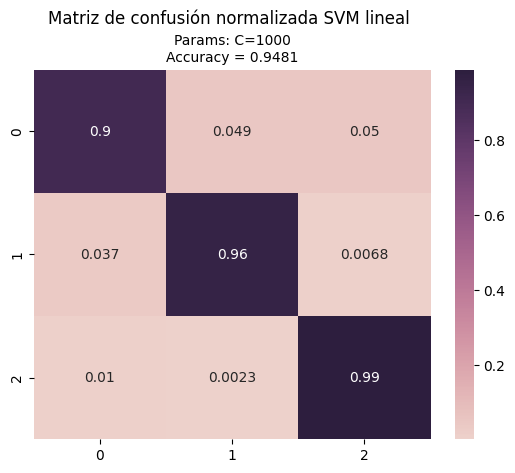

In [ ]:
# y_class_1_2 = y_val[y_val != 3]
print(classification_report(y_val, y_pred_final))

accu_score = accuracy_score(y_val, y_pred_final)
plt.title(f'Params: C={best_model.C}\nAccuracy = {accu_score:.4f}', fontsize = 10)
sns.heatmap(np.round(confusion_matrix(y_val, y_pred_final, normalize='true'), 4), annot=True, cmap=sns.cubehelix_palette(as_cmap=True))
plt.suptitle('Matriz de confusión normalizada SVM lineal', x=0.43, y=1.005)


plt.show()

Se concluye que la clasificación en cascada no mejoró la clasificación global, de manera que se vuelve a este punto inicial, penalizando mucho más el error en la clase 1 para mejorar la clasificación entre 1 y 2

Se calcula la tercera predicción del conjunto de test, esta vez con el clasificador en cascada

In [ ]:
y_test_pred = best_model.predict(df_test)

In [ ]:
print(best_model.classes_)
best_model_2.classes_
print("Shape de clases:", best_model.classes_.shape)

[1. 2. 3.]
Shape de clases: (3,)


In [ ]:
y_pred_1_2 = best_model_2.predict(df_test) # Predicción del conjunto de validación

y_test_pred_1_2 = y_test_pred[y_test_pred != 3]

# Paso 1: máscara de elementos clasificados como 1 o 2 por el primer modelo
mask_1_2 = y_test_pred != 3  # boolean array del mismo largo que y_pred

# Paso 2: inicializa un array con las predicciones del primer modelo
# (esto evitará errores de tamaño o indexación)
y_test_pred_final = y_test_pred.copy()

# Paso 3: reemplaza las posiciones de clase 1 o 2 por la nueva predicción del segundo modelo
y_test_pred_final[mask_1_2] = y_test_pred_1_2

with open('pred_test.csv', 'w') as f:
  f.write('Id,Category\n')
  for i in range(len(df_test)):
    f.write(f'{df_test.index[i]},{int(y_test_pred_final[i])}\n')

# test_pred_function(df_test, best_model)

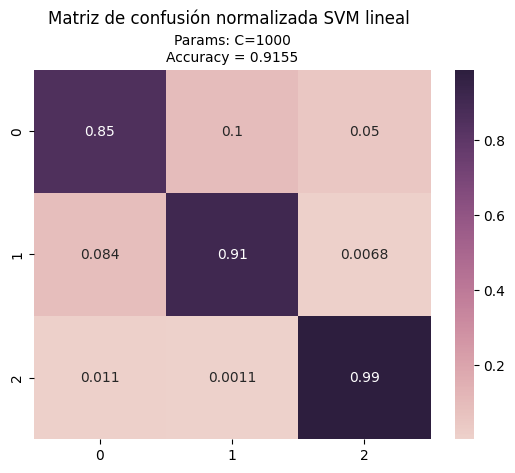

In [ ]:
accu_score = accuracy_score(y_val, y_pred)
plt.title(f'Params: C={best_model.C}\nAccuracy = {accu_score:.4f}', fontsize = 10)
sns.heatmap(np.round(confusion_matrix(y_val, y_pred, normalize='true'), 4), annot=True, cmap=sns.cubehelix_palette(as_cmap=True))
plt.suptitle('Matriz de confusión normalizada SVM lineal', x=0.43, y=1.005)
# for text in disp_norm.text_.ravel():
#     text.set_fontsize(14) # Ajusta fontsize
plt.savefig('conf_mat_svm.svg')

plt.show()

In [ ]:
print("Clases en y_val:", np.unique(y_val))
print("Clases en y_pred:", np.unique(y_pred))

Clases en y_val: [1 2 3]
Clases en y_pred: [1 2 3]


# Borrador

In [ ]:
def calculation_feature_vector(df_data):

  caracs_list = []

  big_data_arr = np.zeros((len(df_data), 18))

  for i in range(0, len(df_data)):
  # for i in range(0, 2):
    data_list = []

    for j in range(1,10):

      if j == 9:
        df_calc = df_data.loc[i, f'Humidity_0':f'Humidity_127'] #display(df_trainval.loc[i, f'Humidity_0':f'Humidity_127'])
      else:
        df_calc = df_data.loc[i, f'R{j}_0':f'R{j}_127'] #display(df_trainval.loc[i, f'R{j}_0':f'R{j}_127'])

      if i == 0:
        caracs_list.append('mean_' + str(j))
        caracs_list.append('var_' + str(j))
        caracs_list.append('mad_' + str(j)) # Desde aquí es el nuevo vector de carcaterísticas que debería haber probado desde un principio
        caracs_list.append('max_' + str(j))

        caracs_list.append('min_' + str(j))
        caracs_list.append('sma_' + str(j))
        caracs_list.append('enrgy_' + str(j))
        caracs_list.append('iqr_' + str(j))

        caracs_list.append('entpy_' + str(j))
        caracs_list.append('arCoeff_' + str(j))
        caracs_list.append('corr_' + str(j))

        df = pd.DataFrame(columns=caracs_list)

      data_list.append(np.mean(df_calc))
      data_list.append(np.var(df_calc))
      data_list.append(np.median(np.abs(df_calc - np.median(df_calc))))
      data_list.append(np.max(df_calc))

      data_list.append(np.min(df_calc))
      data_list.append(np.sum(np.abs(df_calc)))
      data_list.append(np.sum(df_calc**2)/len(df_calc))
      data_list.append(sp.stats.iqr(df_calc))

      data_list.append(sp.stats.entropy(df_calc))
      data_list.append(arr_coef) # No sé como implementar esto en python pero puedes dejarlo en este formato para cuando descubra la librería que permite calcular esta característica
      data_list.append(np.corrcoef(df_calc[:-1], df_calc[1:])[0][1])


    big_data_arr[i,:] = np.array(data_list)

  df = pd.DataFrame(big_data_arr, columns=caracs_list)

  if 'class' in df_data.columns:
    df = pd.concat([df, df_data['class']], axis=1)

  return df

Se organizan los datos en un array de la forma i,j,k, se hace esto para facilitar la programación del cálculo de características

In [ ]:
array_train_val = np.zeros((len(df_trainval), 9, 128)) # Matriz -> n° de muestras X n° de sensores X tamaño de la ventana  ->  [8795, 8, 127]

k = array_train_val.shape[-1]

for i in range(array_train_val.shape[0]):

  for j in range(array_train_val.shape[1]):

    array_train_val[i,j,:] = np.array(df_trainval.loc[i][j*k : k + j*k])

In [ ]:
print(array_train_val[0,0,:].shape)
np.array(df_trainval.loc[0][2*128 : 128 + 2*128]).shape

(128,)


(128,)

In [ ]:
train_val_caracs = pd.DataFrame()
# np.zeros((len(df_trainval), 18)) # Matriz -> n° de muestras X n° de sensores X tamaño de la ventana  ->  [8795, 8, 127]

column_names_caracs = []

for i in range(array_train_val.shape[0]):
  means = []
  variances = []

  print(i)

  for j in range(array_train_val.shape[1]):

    means.append(np.mean(array_train_val[i,j,:]))
    variances.append(np.var(array_train_val[i,j,:]))

    if i == 0:
      column_names_caracs.append('mean_' + str(j+1))
      column_names_caracs.append('vars_' + str(j+1))

  display(pd.DataFrame(means).concat(pd.DataFrame(variances)))


  # train_val_caracs = train_val_caracs.append(pd.Series(means + variances), ignore_index=True)

# train_val_caracs

NameError: name 'array_train_val' is not defined

In [ ]:
df_trainval_caracs = pd.DataFrame(array_train_caracs, columns=column_names_caracs)
df_trainval_caracs
# array_train_val[0,0,:]

,mean_1,mean_2,mean_3,mean_4,mean_5,mean_6,mean_7,mean_8,mean_9
0,12.754292,10.025339,10.148645,11.289939,11.385055,18.354793,4.825439,5.305171,60.131052
1,11.967599,8.068474,8.285822,7.607900,11.844489,16.910116,2.535805,3.026097,65.021354
2,10.874177,6.733694,4.255943,8.015534,14.331759,14.787651,1.883080,2.149658,56.372610
3,12.554823,9.927928,10.074674,11.206576,10.498980,16.661062,7.049197,7.333878,64.552841
4,8.396118,5.376859,3.503016,6.654920,5.419658,14.696602,2.338161,2.889587,58.124579
...,...,...,...,...,...,...,...,...,...
8791,12.412083,9.383410,9.548767,10.667314,10.898194,18.001598,5.556913,6.264065,50.446031
8792,12.834633,9.708894,9.818239,10.988033,19.437108,17.201457,6.097525,6.517089,53.291634
8793,11.981392,9.590782,9.755056,11.072576,10.708553,16.235656,6.379035,7.499586,67.555945
8794,12.913830,10.145803,10.285827,11.450341,11.323898,17.286553,6.387599,6.876442,52.303113


In [ ]:
caracs_list = []

big_data_arr = np.zeros((len(df_trainval), 18))

for i in range(0, len(df_trainval)):
  data_list = []

  for j in range(1,10):

    if j == 9:
      df_calc = df_trainval.loc[i, f'Humidity_0':f'Humidity_127'] #display(df_trainval.loc[i, f'Humidity_0':f'Humidity_127'])
    else:
      df_calc = df_trainval.loc[i, f'R{j}_0':f'R{j}_127'] #display(df_trainval.loc[i, f'R{j}_0':f'R{j}_127'])

    if i == 0:
      caracs_list.append('mean_' + str(j))
      caracs_list.append('var_' + str(j))

      df_train_val = pd.DataFrame(columns=caracs_list)

    data_list.append(np.mean(df_calc))
    data_list.append(np.var(df_calc))

  big_data_arr[i,:] = np.array(data_list)

df_train_val = pd.DataFrame(big_data_arr, columns=caracs_list)
df_train_val = pd.concat([df_train_val, df_trainval['class']], axis=1)
df_train_val
# display(array_train_caracs)
# print(big_data_arr)

,mean_1,var_1,mean_2,var_2,mean_3,var_3,mean_4,var_4,mean_5,var_5,mean_6,var_6,mean_7,var_7,mean_8,var_8,mean_9,var_9,class
0,12.754292,1.906951e-04,10.025339,2.522271e-03,10.148645,1.373784e-03,11.289939,0.002741,11.385055,3.019404e-03,18.354793,0.000251,4.825439,1.891078e-04,5.305171,2.026727e-04,60.131052,0.004940,1
1,11.967599,4.615858e-02,8.068474,1.747379e-01,8.285822,1.192520e-01,7.607900,0.037851,11.844489,6.111635e-04,16.910116,0.052403,2.535805,7.630309e-03,3.026097,3.469361e-02,65.021354,0.012975,1
2,10.874177,1.686482e-04,6.733694,8.399944e-03,4.255943,7.255871e-02,8.015534,0.014101,14.331759,4.511163e-05,14.787651,0.020747,1.883080,1.527344e-03,2.149658,1.502168e-03,56.372610,0.005181,1
3,12.554823,9.594409e-06,9.927928,1.547504e-06,10.074674,5.384760e-07,11.206576,0.000003,10.498980,5.700092e-07,16.661062,0.000034,7.049197,1.462127e-07,7.333878,5.272732e-08,64.552841,0.000700,1
4,8.396118,1.375398e-01,5.376859,1.803704e-01,3.503016,2.255354e-01,6.654920,0.032712,5.419658,3.459920e-02,14.696602,1.606592,2.338161,7.527932e-03,2.889587,8.011927e-03,58.124579,0.052991,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8791,12.412083,2.465645e-04,9.383410,1.878341e-04,9.548767,3.238135e-04,10.667314,0.000181,10.898194,7.399777e-05,18.001598,0.000071,5.556913,3.080433e-05,6.264065,1.567876e-05,50.446031,0.129468,3
8792,12.834633,4.851733e-07,9.708894,6.730447e-07,9.818239,2.962567e-06,10.988033,0.000012,19.437108,3.249446e-04,17.201457,0.000003,6.097525,4.279667e-06,6.517089,1.666033e-06,53.291634,0.000174,3
8793,11.981392,1.075543e-04,9.590782,4.493687e-05,9.755056,3.997650e-05,11.072576,0.000064,10.708553,3.387687e-05,16.235656,0.000048,6.379035,6.832402e-06,7.499586,5.392002e-05,67.555945,0.029843,3
8794,12.913830,2.502985e-04,10.145803,5.793843e-05,10.285827,7.715424e-06,11.450341,0.000036,11.323898,2.544722e-03,17.286553,0.001164,6.387599,3.191764e-05,6.876442,5.058336e-05,52.303113,0.003369,3
